In [945]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from scipy.integrate import solve_ivp
import scipy.optimize as sc_opt
import math
from scipy.integrate import quad
import time
from IPython.core.debugger import set_trace
import datetime as dt

from numpy import genfromtxt

import sys
sys.path.append('../models')

from models import firstordermodel, secondordermodel
from tools import stochasticSimulation, derive_regimes, solve_ivp_discrete, \
                    smooth_dap, sol_ivp_wrapper, smooth_regime, cost, sigmoid

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

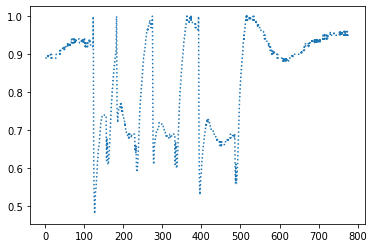

In [916]:
data_full = pd.read_csv('/Users/madsobdrup/Dropbox/Skole/DTU/Studie/MASTER/CODE/switching_time_optimization/data/high_tc_20190913.csv', sep = ';', encoding="latin1", header = 0, index_col = 0)


data_full.index = pd.to_datetime(data_full.index, format='%Y-%m-%d %H:%M:%S')
data = data_full.filter(['A40_A_CompCap'], axis=1)
data['A40_A_CompCap'] = data['A40_A_CompCap']/100
data['t'] = 60 * data_full.index.hour + data_full.index.minute + 1/60 * data_full.index.second
data['t'] = data['t'] - data['t'][0]


plt.plot(data['t'], data['A40_A_CompCap'], ls = 'dotted')

## First order model

In [982]:
# Define model
lambda_MELT = 0.00183*60
lambda_IDLE = 0.00085*60
mu_MELT = 66.92400 
mu_IDLE = 94.89100
sigma = 0.28130
R = 1.96580
pars = np.array([mu_IDLE, mu_MELT, lambda_IDLE, lambda_MELT, sigma, R])
m1 = firstordermodel(pars)

T = 60 * 24
x0 = 90


# Extract switch solution from C++
switches = genfromtxt('results/optimal_pars.csv', delimiter=',')
tau_IDLE_all, tau_MELT_all = derive_regimes(switches,T,1)
tau_IDLE, tau_MELT = derive_regimes(switches,T,0)

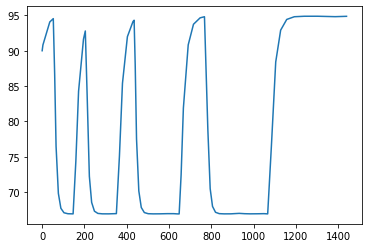

In [983]:
# Plot solution
sol = solve_ivp(m1.f, [0, T], [x0], args=(tau_MELT_all,tau_IDLE_all))
plt.plot(sol.t,sol.y[0])

## Second order model

In [949]:
# Define model
mu_IDLE = 857.67384863 
mu_MELT = 686.5294216
omega_IDLE = 0.0597560
omega_MELT = 0.2612345
xi_IDLE = 0.3504557
xi_MELT = 0.3426913
logsigma = np.array([-7.7329708, 2.0893133])
logR = -7.0306394

pars = np.array([mu_IDLE, mu_MELT, omega_IDLE, omega_MELT, xi_IDLE, xi_MELT, logsigma, logR])
m2 = secondordermodel(pars)

### With test switches from data

In [944]:
x = sol.y[1]
slope = 1/1000


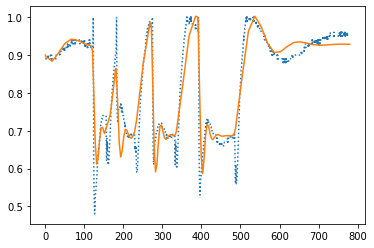

In [984]:
T = data['t'][-1]
switches_data = pd.to_datetime(["2019-09-17 13:00:00",
                 "2019-09-17 13:30:00",
                 "2019-09-17 14:00:00",
                 "2019-09-17 14:45:00",
                 "2019-09-17 15:30:00",
                 "2019-09-17 16:30:00",
                 "2019-09-17 17:30:00",
                 "2019-09-17 19:00:00"])
switches_data = (60 * (switches_data.hour - data_full.index.hour[0]) + switches_data.minute - data_full.index.minute[0]).astype(int)
tau_IDLE_all_data, tau_MELT_all_data = derive_regimes(switches_data,T,1)
x0 = np.array([2.6659426, 899.8884004])
sol = solve_ivp(m2.f, [0, T], [x0[0], x0[1]], args=(tau_MELT_all_data,tau_IDLE_all_data))
plt.plot(data['t'], data['A40_A_CompCap'], ls = 'dotted')
plt.plot(sol.t, sol.y[1]/1000)



### With switches from c++ example (with example cost function!)

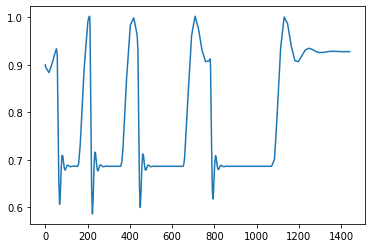

In [985]:
T = 60 * 24
x0 = np.array([2.6659426, 899.8884004])
sol = solve_ivp(m2.f, [0, T], [x0[0], x0[1]], args=(tau_MELT_all,tau_IDLE_all))
plt.plot(sol.t, sol.y[1] * 1/1000)

## Model simulation

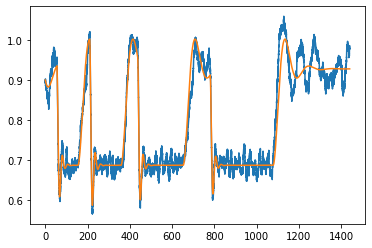

In [986]:
# Simulate from model
tf = 60*24
dt = 0.01
x0 = np.array([2.6659426, 899.8884004])
#x0 = np.array([90])
np.random.seed(144257)
T, X, Y, Z = stochasticSimulation(m2,switches,x0,tf,dt)
T_ode, X_ode, Z_ode = solve_ivp_discrete(m2,x0,switches,tf,T)
plt.plot(T,Z)
plt.plot(T_ode, Z_ode)

#T_ode2, X_ode2, Z_ode2,  = sol_ivp_wrapper(m1,x0,switches,tf,T)
#plt.plot(T_ode2, Z_ode2)

In [987]:
# Day Ahead Prices and power constants
dap = 1/1000000 * np.array([15.5,31.,21.,35.,36.,35.,28.,33.,28.,41.,44.,36.,32.,28.,24.,25.,34.,36.,41.,37.,35.,39.,34.,24.])
k = 12400.
k_MELT = 250.
k_IDLE = 9.

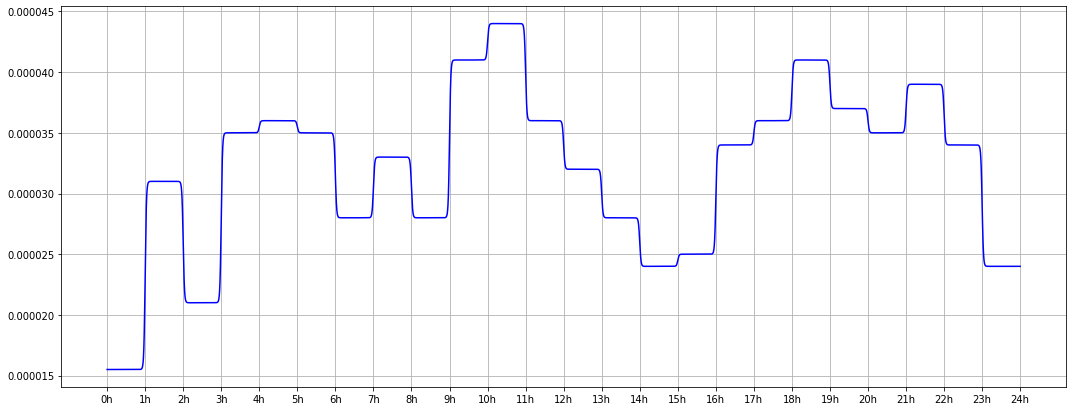

In [988]:
fig = plt.figure(figsize=(18,7))    
ax = fig.add_subplot(111)
ax.plot(T,smooth_dap(dap,T),color='b')
ax.set_xticks(np.arange(0,dap.size+1,1)*60.)
ax.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,dap.size+1,1) * 60.])
ax.grid()

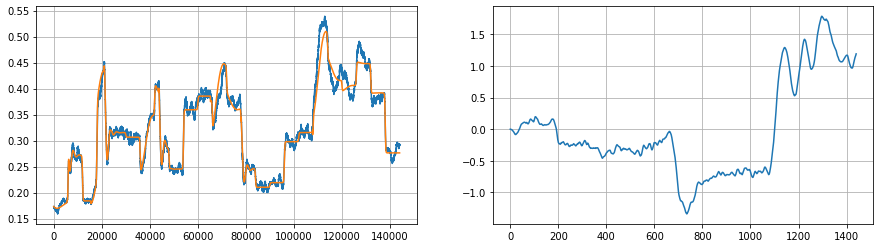

In [1011]:
cost_true, cost_acc_true = cost(Z,T,switches,dap,k,k_MELT,k_IDLE)
cost_exp, cost_acc_exp = cost(Z_ode,T_ode,switches,dap,k,k_MELT,k_IDLE)

fig = plt.figure(figsize = (15,4))
ax = fig.add_subplot(121)
plt.plot(cost_true)
plt.plot(cost_exp)
ax.grid()

ax = fig.add_subplot(122)
plt.plot(T[1:],cost_acc_true - cost_acc_exp)
ax.grid()

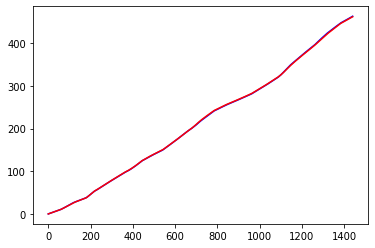

In [1012]:
plt.plot(T[1:],cost_acc_true, color = 'blue')
plt.plot(T_ode[1:],cost_acc_exp, color = 'red')

## Loop : Plan 2 days, simulate 1 day

In [1013]:
nswitches = 10
tf_sim = 60 * 24
tf_ph = 60 * 48

In [1190]:
prices = pd.read_csv('../data/elspot-prices_2013_hourly_dkk.csv', index_col=0, skiprows=2,header=0)  
prices = prices[{'Hours','DK1'}]
prices = prices.apply(lambda x: x.str.replace(',','.'))
prices


,DK1,Hours
01-01-2013,104.66,00 - 01
01-01-2013,82.5,01 - 02
01-01-2013,63.41,02 - 03
01-01-2013,0.75,03 - 04
01-01-2013,14.99,04 - 05
...,...,...
31-12-2013,226.01,19 - 20
31-12-2013,209.97,20 - 21
31-12-2013,149.63,21 - 22
31-12-2013,214.6,22 - 23


In [1196]:
prices['DK1'][48]

'187.01'

In [1034]:
X = np.zeros([n_days, nx, 60 * 24])

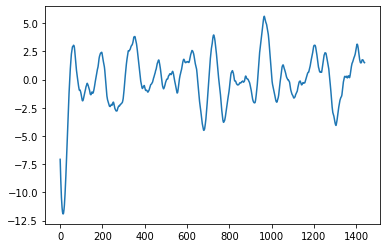

In [1070]:
Xmat = np.matrix(X_tmp)
Xsub = Xmat[:,::int(1/dt)]
plt.plot(np.squeeze(np.array(Xsub[0,:])))

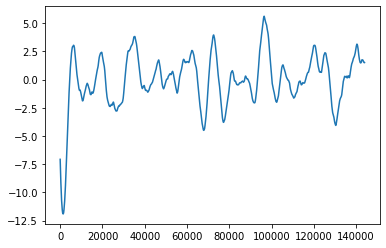

In [1072]:
plt.plot(X_tmp[0])

 ...]

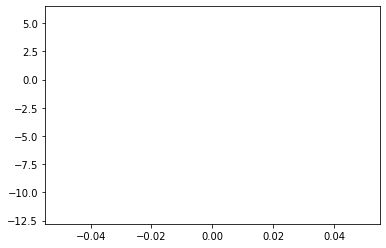

In [1052]:
plt.plot(np.matrix(X_tmp)[:,::int(1/dt)][0,:])

In [1047]:
1/ 0.01

100.0

In [1080]:
X_tmp[:,::int(1/dt)]

array([[ -7.0728371 ,  -7.78038447,  -8.40719196, ...,   1.51495683,
          1.498966  ,   1.49517836],
       [635.88877072, 650.11937487, 664.98123338, ..., 932.56984327,
        945.46611742, 944.37890056]])

In [1092]:
nx,dt
day = 0

In [1093]:
X = np.zeros([n_days, nx, 60 * 24])
X[day,:] = X_tmp[:,::int(1/dt)]
X

array([[[ -7.0728371 ,  -7.78038447,  -8.40719196, ...,   1.51495683,
           1.498966  ,   1.49517836],
        [635.88877072, 650.11937487, 664.98123338, ..., 932.56984327,
         945.46611742, 944.37890056]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]],

       ...,

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
       

In [1103]:
X.transpose(1,0,2).reshape(nx,-1)

array([[ -7.0728371 ,  -7.78038447,  -8.40719196, ...,   0.        ,
          0.        ,   0.        ],
       [635.88877072, 650.11937487, 664.98123338, ...,   0.        ,
          0.        ,   0.        ]])

In [ ]:
X[:,(day * 60 * 24):((day+1) * 60 * 24)]

In [1108]:
nnp.zeros([nx, n_days, 60 * 24])

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [1146]:
nswitches

10

In [1177]:
int(1/dt)

100

In [1179]:
T_tmp[::int(1/dt)]

array([1.00000e-02, 1.01000e+00, 2.01000e+00, ..., 1.43701e+03,
       1.43801e+03, 1.43901e+03])

In [1213]:
np.random.seed(1236)

# Simulate parameters
n_days = 2
dt = 0.01

# Initialize process
x0 = np.array([2.6659426, 899.8884004])

# Initialzie history
history = {}
history['X'] = np.zeros([n_days, nx, 60 * 24])
history['Z'] = np.zeros([n_days, 60 * 24])
history['Z_ode'] = np.zeros([n_days, 60 * 24])
history['T'] = np.zeros([n_days, 60 * 24])

history['SWITCHES'] = np.zeros([n_days, nswitches])
history['PRICES'] = np.zeros([n_days, 48])

history['expected_price'] = np.zeros(n_days)
history['true_price'] = np.zeros(n_days)

for day in range(n_days):
    print(day)
    
    # Extract variables related to the day
    idx = np.arange(48) + day * 48
    future_days = np.array(prices.index[idx])
    future_hours = np.array(prices['Hours'][idx])
    future_price = np.array(prices['DK1'][idx]).astype(np.float)


    # ---------------------------
    # Compute optimal switches over 2 days
    # ---------------------------

    # To be changed to C++ optimizer
    switch_opt = np.sort(np.random.uniform(0,tf_ph,nswitches))


    # ---------------------------
    # Simulate 1 day
    # ---------------------------
    switch_sim = switch_opt
    #nswicthes_switches_in_ph = np.sum(switch_opt < tf_sim) + np.sum(switch_opt < tf_sim) % 2
    #switch_sim = switch_opt[switch_opt < tf_sim]
    
    # Consider only saving every 1 minutes of the simulation
    T_tmp, X_tmp, Y_tmp, Z_tmp = stochasticSimulation(m2,switch_sim,x0,tf_sim,dt)
    T_tmp_ode, X_tmp_ode, Z_tmp_ode = solve_ivp_discrete(m2,x0,switch_sim,tf_sim,T_tmp)


    # ---------------------------
    # Compute Cost
    # ---------------------------
    dap = 1/1000000 * future_price[:24]
    cost_true, cost_acc_true = cost(Z_tmp,T_tmp,switches,dap,k,k_MELT,k_IDLE)
    cost_exp, cost_acc_exp = cost(Z_tmp_ode,T_tmp_ode,switches,dap,k,k_MELT,k_IDLE)



    # ---------------------------
    # Update variables
    # ---------------------------

    # Process
    x0 = np.array([X_tmp[i][-1] for i in range(nx)])

    # Update monitored variables
    history['expected_price'][day] = cost_true[-1]
    history['true_price'][day] = cost_exp[-1]
    
    history['Z'][day] = Z_tmp[::int(1/dt)]
    history['Z_ode'][day] = Z_tmp_ode[::int(1/dt)]
    history['X'][day,:] = X_tmp[:,::int(1/dt)]
    history['T'][day] = T_tmp[::int(1/dt)] # Same in each day
    history['SWITCHES'][day,:] = switch_opt
    history['PRICES'][day,:] = future_price

0
1
2
3
4


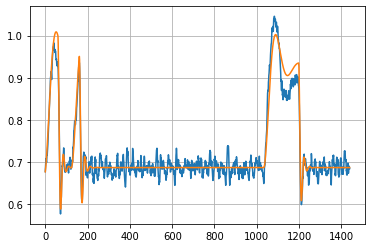

In [1223]:
day = 1
plt.plot(history['T'][0],history['Z'][day])
plt.plot(history['T'][0],history['Z_ode'][day])
plt.grid()

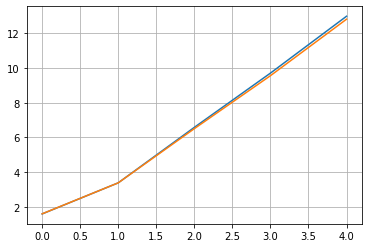

In [1222]:
plt.plot(range(n_days),np.cumsum(history['expected_price']))
plt.plot(range(n_days),np.cumsum(history['true_price']))
plt.grid()

# Prepare dataset for Pytorch

In [1228]:
target = history['SWITCHES']
target.shape

(5, 10)

In [1229]:
history['Z'][:,0].shape

(5,)

In [1263]:
scaler = MinMaxScaler()

switch = history['SWITCHES']
z0 = np.expand_dims(history['Z'][:,0], axis=1)
price = history['PRICES']
numpy_data = np.hstack((switch, z0, price))
train_data = scaler.fit_transform(numpy_data)


In [1295]:
train_data.shape[0]

5

In [1286]:
__len__ = numpy_data.shape[1]

index = [1,2]
x = numpy_data[index,(nswitches):]
y = train_data[index,:nswitches]


In [1262]:
numpy_data

array([[6.24181696e+02, 7.43036647e+02, 7.54700568e+02, 1.05231115e+03,
        1.16815706e+03, 1.25364137e+03, 1.40154635e+03, 1.67648387e+03,
        2.25524666e+03, 2.65654560e+03, 8.99150172e-01, 1.04660000e+02,
        8.25000000e+01, 6.34100000e+01, 7.50000000e-01, 1.49900000e+01,
        1.70150000e+02, 2.08340000e+02, 2.08940000e+02, 2.07370000e+02,
        2.04020000e+02, 2.10510000e+02, 2.25800000e+02, 2.25800000e+02,
        2.31390000e+02, 2.41390000e+02, 2.50940000e+02, 2.56830000e+02,
        2.70330000e+02, 2.76900000e+02, 2.71080000e+02, 2.70780000e+02,
        2.50560000e+02, 2.58470000e+02, 1.89020000e+02, 1.76120000e+02,
        1.11300000e+02, 1.22710000e+02, 8.81000000e+01, 8.94400000e+01,
        2.21320000e+02, 2.31470000e+02, 3.31050000e+02, 2.94050000e+02,
        2.87490000e+02, 2.88530000e+02, 2.87120000e+02, 2.83980000e+02,
        2.83090000e+02, 2.82790000e+02, 2.89800000e+02, 2.97780000e+02,
        3.02260000e+02, 2.95550000e+02, 2.89060000e+02, 2.794300

In [1250]:
np.expand_dims(history['Z'][:,0], axis=1).shape

(5, 1)

In [1255]:
history['PRICES'].shape

(5, 48)